In [3]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# --- Step 1: Handle Categorical Data ---

# Drop the 'id' column (it's just an index) and 'attack_cat' (we'll use the numerical 'label')
df = df.drop(['id', 'attack_cat'], axis=1)

# Perform one-hot encoding on the categorical columns
df_processed = pd.get_dummies(df, columns=['proto', 'service', 'state'], dtype=float)


# --- Step 2: Separate Features and Labels ---

X = df_processed.drop('label', axis=1)
y = df_processed['label']


# --- Step 3: Scale Numerical Features ---

# Initialize the scaler
scaler = MinMaxScaler()

# Fit the scaler on the features and transform them
X_scaled = scaler.fit_transform(X)

# --- Verification ---
print("Data preprocessing complete.")
print("Shape of the final features (X_scaled):", X_scaled.shape)
print("\nFirst 5 rows of the scaled data:")
print(X_scaled[:5])

Data preprocessing complete.
Shape of the final features (X_scaled): (82332, 190)

First 5 rows of the scaled data:
[[1.83333367e-07 9.39408173e-05 0.00000000e+00 3.28788116e-05
  0.00000000e+00 9.09090899e-02 9.96078431e-01 0.00000000e+00
  3.42375898e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.83302807e-07 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 1.51351351e-01
  0.00000000e+00 0.00000000e+00 0.00000000e+00 1.61290323e-02
  3.33333333e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.61290323e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.63934426e-02 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00

In [5]:
## Step 3: LSTM Autoencoder - Data Preparation
## This step filters the data to get only the 'normal' records and reshapes it for the LSTM model.

In [7]:
import numpy as np

# --- Filter for only normal data (where label y == 0) ---
X_normal = X_scaled[y == 0]
print("Shape of normal data:", X_normal.shape)


# --- Reshape the data for the LSTM model ---
# The LSTM needs data in a 3D format: [samples, timesteps, features]
# We will treat each row as a single timestep.
X_normal_reshaped = X_normal.reshape(X_normal.shape[0], 1, X_normal.shape[1])

print("Shape of reshaped normal data:", X_normal_reshaped.shape)

Shape of normal data: (37000, 190)
Shape of reshaped normal data: (37000, 1, 190)


In [8]:
## Step 4: LSTM Autoencoder - Build and Train Model


In [9]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense

# --- Define the Autoencoder Architecture ---
input_dim = X_normal_reshaped.shape[2] # Number of features
latent_dim = 64 # Size of the compressed representation

# Encoder
inputs = Input(shape=(1, input_dim))
encoder = LSTM(latent_dim, activation='relu')(inputs)

# Decoder
decoder = RepeatVector(1)(encoder)
decoder = LSTM(input_dim, activation='relu', return_sequences=True)(decoder)
output = TimeDistributed(Dense(input_dim))(decoder)

# Create the autoencoder model
autoencoder = Model(inputs=inputs, outputs=output)


# --- Compile and Train the Model ---
autoencoder.compile(optimizer='adam', loss='mse')

# Train the model on the reshaped NORMAL data
history = autoencoder.fit(
    X_normal_reshaped,
    X_normal_reshaped, # The model learns to reconstruct its own input
    epochs=10,
    batch_size=64,
    validation_split=0.1 # Use 10% of the data for validation
)

print("\nLSTM Autoencoder training complete.")
autoencoder.summary()

2025-08-24 13:47:48.598152: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-24 13:47:48.612713: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-24 13:47:49.105784: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-24 13:47:50.611907: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation or

Epoch 1/10


E0000 00:00:1756057671.984097   10888 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1756057672.040477   10888 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


 33/521 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0299

2025-08-24 13:47:52.832718: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT32 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


521/521 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0044 - val_loss: 3.7338e-04
Epoch 2/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.9926e-04 - val_loss: 1.9791e-04
Epoch 3/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.6267e-05 - val_loss: 1.2412e-04
Epoch 4/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.1597e-05 - val_loss: 9.0518e-05
Epoch 5/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.1827e-05 - val_loss: 5.6354e-05
Epoch 6/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.9339e-05 - val_loss: 4.0597e-05
Epoch 7/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.1473e-05 - val_loss: 2.6753e-05
Epoch 8/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.6571e-05 - val_loss: 2.0812e-05
Epoch 9/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.3671e-05 - val_loss: 1.8666e-05
Epoch 10/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1742e-05 - val_loss: 1.7815e-05

LSTM Autoencoder training complete.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1, 190)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        65,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 1, 190)         │       193,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 1, 190)         │        36,290 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 886,112 (3.38 MB)

 Trainable params: 295,370 (1.13 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 590,742 (2.25 MB)

In [10]:
## Step 5: LSTM - Calculate Reconstruction Errors
## Use the trained autoencoder to predict the entire dataset and calculate the Mean Squared Error (MSE) for each record. This error is our anomaly score.

In [11]:
import numpy as np

# --- Reshape the entire dataset for the LSTM ---
X_scaled_reshaped = X_scaled.reshape(X_scaled.shape[0], 1, X_scaled.shape[1])

# --- Get the model's predictions (the reconstructed data) ---
predictions = autoencoder.predict(X_scaled_reshaped)

# --- Calculate the Mean Squared Error (MSE) for each record ---
# This MSE is our "reconstruction error" or anomaly score.
mse = np.mean(np.power(X_scaled_reshaped - predictions, 2), axis=2)

# --- Add the scores to our original dataframe ---
# We'll use the original 'df' before it was one-hot encoded to keep it simple.
df['lstm_score'] = mse

print("LSTM anomaly scores calculated and added to the dataframe.")
print("\nFirst 5 rows with their scores:")
print(df.head())

print("\nSummary of scores for normal vs. anomalous data:")
print(df.groupby('label')['lstm_score'].describe())

2573/2573 ━━━━━━━━━━━━━━━━━━━━ 2s 781us/step
LSTM anomaly scores calculated and added to the dataframe.

First 5 rows with their scores:
        dur proto service state  spkts  dpkts  sbytes  dbytes         rate  \
0  0.000011   udp       -   INT      2      0     496       0   90909.0902   
1  0.000008   udp       -   INT      2      0    1762       0  125000.0003   
2  0.000005   udp       -   INT      2      0    1068       0  200000.0051   
3  0.000006   udp       -   INT      2      0     900       0  166666.6608   
4  0.000010   udp       -   INT      2      0    2126       0  100000.0025   

   sttl  ...  ct_dst_sport_ltm  ct_dst_src_ltm  is_ftp_login  ct_ftp_cmd  \
0   254  ...                 1               2             0           0   
1   254  ...                 1               2             0           0   
2   254  ...                 1               3             0           0   
3   254  ...                 1               3             0           0   
4   254  ...  

In [12]:
## Step 6: Statistical Model (Isolation Forest)
## Here we build the statistical component of the hybrid model. We use an Isolation Forest, trained only on normal data, to calculate a second anomaly score.

In [13]:
from sklearn.ensemble import IsolationForest

# --- Initialize and train the Isolation Forest model ---
# We train it only on the normal data (X_normal from the previous step).
# contamination='auto' is a standard setting, and random_state ensures reproducibility.
iso_forest = IsolationForest(contamination='auto', random_state=42)
iso_forest.fit(X_normal)

# --- Calculate anomaly scores for the entire dataset ---
# The decision_function() gives scores where lower values are more anomalous.
# We'll invert the scores (multiply by -1) so that a HIGHER score means more anomalous.
statistical_scores = -iso_forest.decision_function(X_scaled)

# --- Add the scores to our dataframe ---
df['statistical_score'] = statistical_scores

print("Statistical anomaly scores calculated and added to the dataframe.")
print("\nSummary of scores for normal vs. anomalous data:")
print(df.groupby('label')['statistical_score'].describe())

Statistical anomaly scores calculated and added to the dataframe.

Summary of scores for normal vs. anomalous data:
         count      mean       std       min       25%       50%       75%  \
label                                                                        
0      37000.0 -0.088666  0.048895 -0.156941 -0.130560 -0.089255 -0.060687   
1      45332.0 -0.022269  0.078345 -0.155344 -0.082058 -0.028035  0.035823   

            max  
label            
0      0.118047  
1      0.155766  


In [ ]:
## Step 7: Fuse Model Scores
## Normalize the scores from both models and combine them into a final composite score using the weights specified in the research paper.

In [14]:
from sklearn.preprocessing import MinMaxScaler

# --- Normalize both score columns to a 0-1 range ---
# This is a critical step before combining scores that are on different scales.
scaler = MinMaxScaler()
scores_to_normalize = df[['lstm_score', 'statistical_score']]
df[['lstm_score_norm', 'statistical_score_norm']] = scaler.fit_transform(scores_to_normalize)

# --- Calculate the composite score ---
# We use the tuned weights from Table 2 in the paper: 0.4 for statistical, 0.6 for LSTM[cite: 186].
df['composite_score'] = (0.4 * df['statistical_score_norm']) + (0.6 * df['lstm_score_norm'])

print("Composite scores calculated successfully.")
print(df[['label', 'composite_score']].head())

Composite scores calculated successfully.
   label  composite_score
0      0         0.088156
1      0         0.131289
2      0         0.111907
3      0         0.098260
4      0         0.148585


In [ ]:
## Step 8: Final Evaluation
## Set an anomaly threshold and calculate the final performance metrics (Accuracy, Precision, Recall, F1-score) for the hybrid model.

In [15]:
from sklearn.metrics import classification_report, accuracy_score

# --- Determine an anomaly threshold ---
# A common method is to use a high percentile of the composite scores from the known NORMAL data.
# Here, we'll flag anything more anomalous than 95% of the normal data.
threshold = df[df['label'] == 0]['composite_score'].quantile(0.95)
print(f"Anomaly Threshold set to: {threshold:.6f}")

# --- Generate final predictions based on the threshold ---
# If a record's score is above the threshold, we classify it as an anomaly (1).
predictions = (df['composite_score'] > threshold).astype(int)

# --- Calculate and print the evaluation metrics ---
print("\nHybrid Model Evaluation Results:")
print(f"Accuracy: {accuracy_score(df['label'], predictions):.4f}")
print("\nClassification Report:")
print(classification_report(df['label'], predictions, target_names=['Normal (0)', 'Anomaly (1)']))

Anomaly Threshold set to: 0.210333

Hybrid Model Evaluation Results:
Accuracy: 0.7555

Classification Report:
              precision    recall  f1-score   support

  Normal (0)       0.66      0.95      0.78     37000
 Anomaly (1)       0.94      0.60      0.73     45332

    accuracy                           0.76     82332
   macro avg       0.80      0.77      0.75     82332
weighted avg       0.81      0.76      0.75     82332



In [16]:
# --- EXPERIMENT: Try a lower threshold ---
# Let's try the 90th percentile instead of the 95th
new_threshold = df[df['label'] == 0]['composite_score'].quantile(0.90)
print(f"New Anomaly Threshold set to: {new_threshold:.6f}")

# Generate new predictions
new_predictions = (df['composite_score'] > new_threshold).astype(int)

# See the new results
print("\nNew Classification Report:")
print(classification_report(df['label'], new_predictions, target_names=['Normal (0)', 'Anomaly (1)']))

New Anomaly Threshold set to: 0.172965

New Classification Report:
              precision    recall  f1-score   support

  Normal (0)       0.67      0.90      0.77     37000
 Anomaly (1)       0.89      0.64      0.75     45332

    accuracy                           0.76     82332
   macro avg       0.78      0.77      0.76     82332
weighted avg       0.79      0.76      0.76     82332



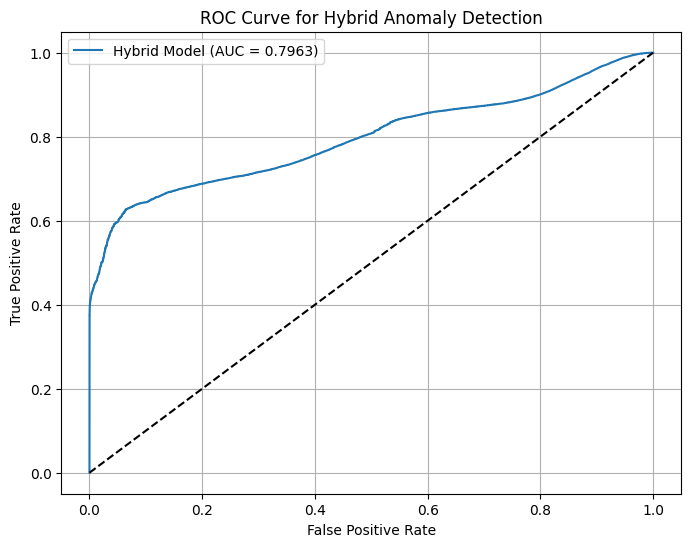

In [17]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# --- Calculate ROC curve and AUC ---
fpr, tpr, thresholds = roc_curve(df['label'], df['composite_score'])
auc_score = roc_auc_score(df['label'], df['composite_score'])

# --- Plot the curve ---
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Hybrid Model (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Hybrid Anomaly Detection')
plt.legend()
plt.grid()
plt.show()

In [ ]:
## Step 9: Save Model Components
## Save the trained models and the scaler to disk for future use.

In [18]:
import joblib

# --- Save the Keras LSTM autoencoder ---
autoencoder.save('lstm_autoencoder.keras')

# --- Save the scikit-learn Isolation Forest model ---
joblib.dump(iso_forest, 'isolation_forest.joblib')

# --- Save the scaler used for normalization ---
joblib.dump(scaler, 'scaler.joblib')

print("All model components have been saved to your project folder!")
print("You can now see 'lstm_autoencoder.keras', 'isolation_forest.joblib', and 'scaler.joblib' in your file list.")

All model components have been saved to your project folder!
You can now see 'lstm_autoencoder.keras', 'isolation_forest.joblib', and 'scaler.joblib' in your file list.


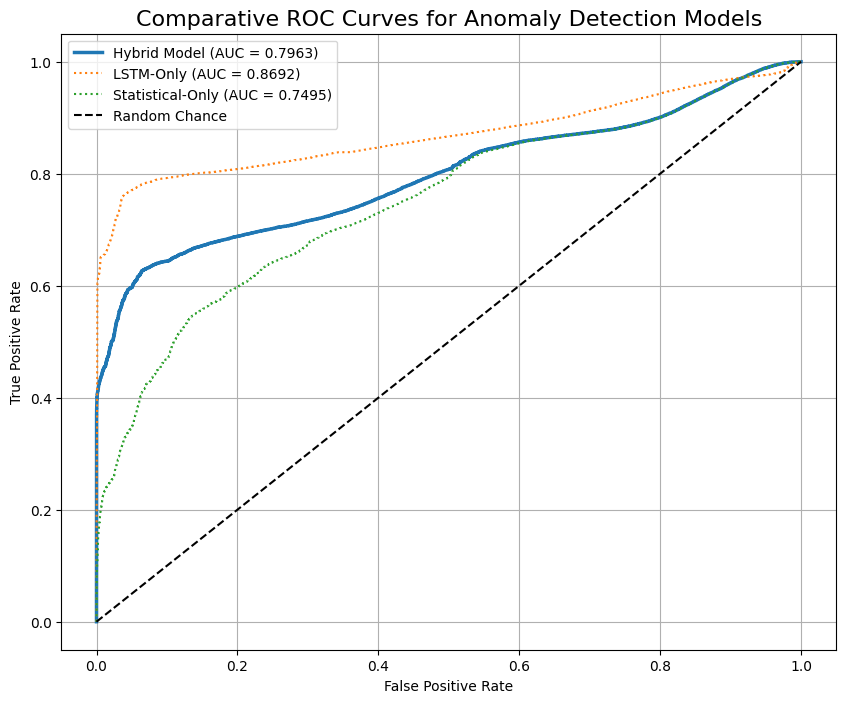

In [33]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# --- Calculate ROC data for all three models ---
# Hybrid Model
fpr_hybrid, tpr_hybrid, _ = roc_curve(df['label'], df['composite_score'])
auc_hybrid = roc_auc_score(df['label'], df['composite_score'])

# LSTM-Only Model
fpr_lstm, tpr_lstm, _ = roc_curve(df['label'], df['lstm_score_norm'])
auc_lstm = roc_auc_score(df['label'], df['lstm_score_norm'])

# Statistical-Only Model
fpr_stat, tpr_stat, _ = roc_curve(df['label'], df['statistical_score_norm'])
auc_stat = roc_auc_score(df['label'], df['statistical_score_norm'])

# --- Plot all curves on one graph ---
plt.figure(figsize=(10, 8))
plt.plot(fpr_hybrid, tpr_hybrid, label=f'Hybrid Model (AUC = {auc_hybrid:.4f})', linewidth=2.5)
plt.plot(fpr_lstm, tpr_lstm, label=f'LSTM-Only (AUC = {auc_lstm:.4f})', linestyle=':')
plt.plot(fpr_stat, tpr_stat, label=f'Statistical-Only (AUC = {auc_stat:.4f})', linestyle=':')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance') # Dashed diagonal

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparative ROC Curves for Anomaly Detection Models', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
## SYNTHETIC DATA

Synthetic dataset created successfully.
            timestamp  sensor_value  label
0 2025-01-01 00:00:00     50.386910      0
1 2025-01-01 00:01:00     50.795920      0
2 2025-01-01 00:02:00     49.478186      0
3 2025-01-01 00:03:00     50.566469      0
4 2025-01-01 00:04:00     50.475505      0

Anomaly counts:
label
0    1848
1     152
Name: count, dtype: int64


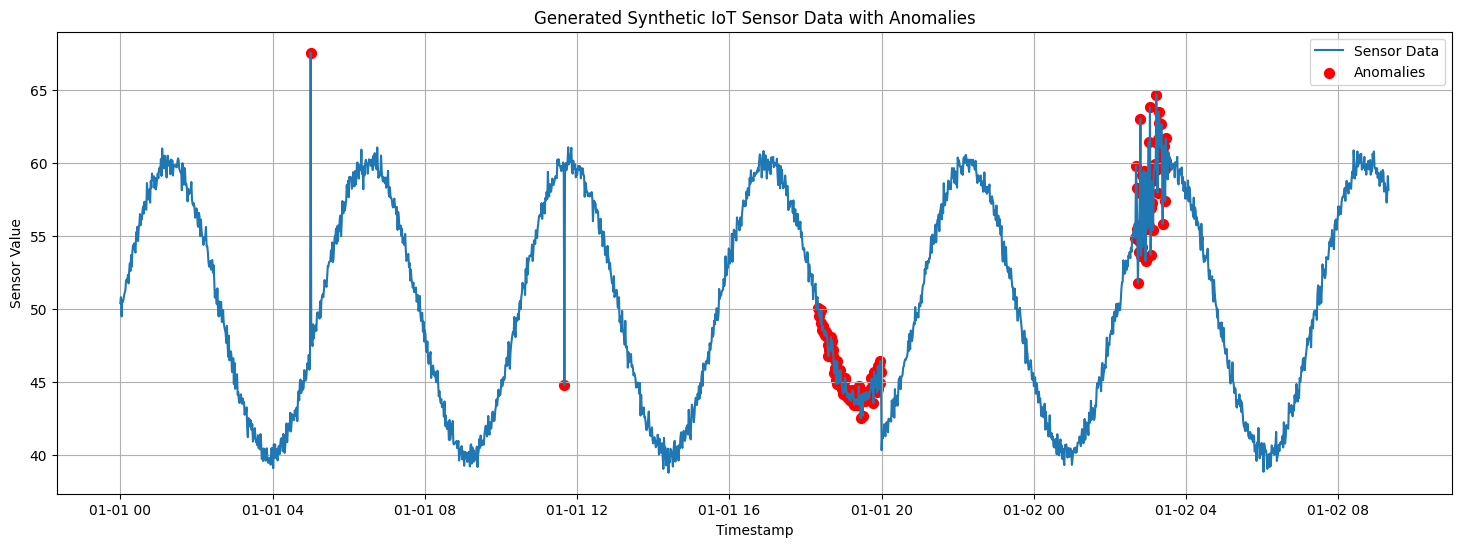

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Set up Parameters ---
n_samples = 2000  # Total number of data points
time = np.arange(n_samples)

# --- 2. Generate the "Normal" Baseline Data ---
# We'll use a sine wave to simulate a cyclical sensor (like daily temperature)
# and add some random noise to make it look realistic.
normal_signal = np.sin(time / 50) * 10 + 50
noise = np.random.normal(0, 0.5, n_samples)
sensor_data = normal_signal + noise

# Initialize labels: 0 for normal, 1 for anomaly
labels = np.zeros(n_samples, dtype=int)

# --- 3. Inject the Four Types of Anomalies ---

# Anomaly 1: Sudden Spike
spike_index = 300
sensor_data[spike_index] += 20
labels[spike_index] = 1

# Anomaly 2: Sudden Drop
drop_index = 700
sensor_data[drop_index] -= 15
labels[drop_index] = 1

# Anomaly 3: Gradual Drift
drift_start = 1100
drift_end = 1200
drift = np.linspace(0, 5, drift_end - drift_start)
sensor_data[drift_start:drift_end] += drift
labels[drift_start:drift_end] = 1

# Anomaly 4: Erratic Fluctuations
erratic_start = 1600
erratic_end = 1650
erratic_noise = np.random.normal(0, 3, erratic_end - erratic_start)
sensor_data[erratic_start:erratic_end] += erratic_noise
labels[erratic_start:erratic_end] = 1

# --- 4. Create the Final DataFrame ---
synthetic_df = pd.DataFrame({
    'timestamp': pd.to_datetime(pd.Series(time), unit='m', origin='2025-01-01'),
    'sensor_value': sensor_data,
    'label': labels
})

print("Synthetic dataset created successfully.")
print(synthetic_df.head())
print("\nAnomaly counts:")
print(synthetic_df['label'].value_counts())


# --- 5. Visualize the Data ---
plt.figure(figsize=(18, 6))
plt.plot(synthetic_df['timestamp'], synthetic_df['sensor_value'], label='Sensor Data')

# Highlight the anomalies in red
anomalies = synthetic_df[synthetic_df['label'] == 1]
plt.scatter(anomalies['timestamp'], anomalies['sensor_value'], color='red', label='Anomalies', s=50)

plt.title('Generated Synthetic IoT Sensor Data with Anomalies')
plt.xlabel('Timestamp')
plt.ylabel('Sensor Value')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# --- 1. Scale the sensor data ---
scaler = MinMaxScaler()
synthetic_df['sensor_scaled'] = scaler.fit_transform(synthetic_df[['sensor_value']])

# --- 2. Prepare data for models ---
X_synthetic = synthetic_df[['sensor_scaled']].values
y_synthetic = synthetic_df['label'].values

# Filter for normal data for training
X_normal_synthetic = X_synthetic[y_synthetic == 0]

# Reshape for LSTM
X_normal_reshaped_synthetic = X_normal_synthetic.reshape(X_normal_synthetic.shape[0], 1, 1)

In [23]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense

# --- Define and train the autoencoder ---
input_dim = 1 # Only one feature now
latent_dim = 16

inputs = Input(shape=(1, input_dim))
encoder = LSTM(latent_dim, activation='relu')(inputs)
decoder = RepeatVector(1)(encoder)
decoder = LSTM(input_dim, activation='relu', return_sequences=True)(decoder)
output = TimeDistributed(Dense(input_dim))(decoder)

autoencoder_synth = Model(inputs=inputs, outputs=output)
autoencoder_synth.compile(optimizer='adam', loss='mse')

autoencoder_synth.fit(
    X_normal_reshaped_synthetic,
    X_normal_reshaped_synthetic,
    epochs=10,
    batch_size=32,
    validation_split=0.1
)

Epoch 1/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2039 - val_loss: 0.2353
Epoch 2/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1689 - val_loss: 0.1980
Epoch 3/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - loss: 0.1407 - val_loss: 0.1678
Epoch 4/10
52/52 ━━━━━━━━━━━━━━━━━━━━ -8s -152240us/step - loss: 0.1185 - val_loss: 0.1430
Epoch 5/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1014 - val_loss: 0.1235
Epoch 6/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0885 - val_loss: 0.1085
Epoch 7/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0790 - val_loss: 0.0972
Epoch 8/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0722 - val_loss: 0.0883
Epoch 9/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0675 - val_loss: 0.0819
Epoch 10/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0644 - val_loss: 0.0770


In [24]:
from statsmodels.tsa.arima.model import ARIMA

# --- Fit the ARIMA model on normal data ---
# We use a simple ARIMA(5,1,0) model as a starting point
model = ARIMA(X_normal_synthetic, order=(5,1,0))
model_fit = model.fit()

# --- Get residuals as anomaly scores ---
# The 'residuals' are the errors between the model's predictions and the actual data
residuals = pd.DataFrame(model_fit.resid)
# We use the absolute value of the residual as the score
synthetic_df['arima_score'] = pd.Series(residuals.abs().values.flatten())
synthetic_df['arima_score'].fillna(0, inplace=True) # Fill NaN for the first few values

/tmp/ipykernel_10888/4109899612.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  synthetic_df['arima_score'].fillna(0, inplace=True) # Fill NaN for the first few values


In [25]:
# --- Calculate LSTM scores ---
X_synthetic_reshaped = X_synthetic.reshape(X_synthetic.shape[0], 1, 1)
predictions = autoencoder_synth.predict(X_synthetic_reshaped)
mse = np.mean(np.power(X_synthetic_reshaped - predictions, 2), axis=2)
synthetic_df['lstm_score'] = mse

# --- Fuse and Evaluate (same as before) ---
# ... (Normalize scores, calculate composite score, set threshold, print classification_report) ...

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


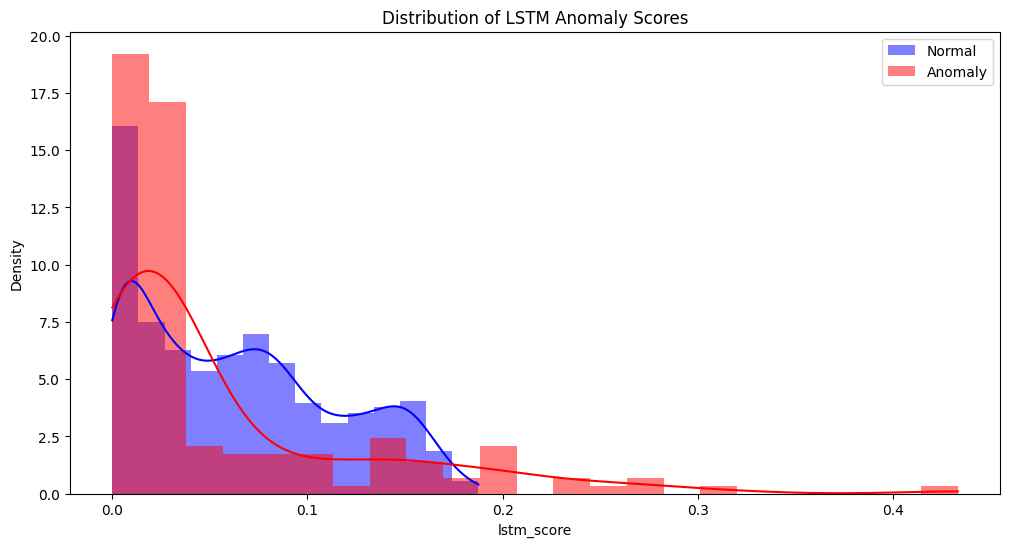

DEFINITIVE Anomaly Threshold (from LSTM only): 0.175612

--- Final LSTM-Only Model Evaluation on Synthetic Data ---
Accuracy: 0.9260

Classification Report:
              precision    recall  f1-score   support

  Normal (0)       0.93      0.99      0.96      1848
 Anomaly (1)       0.58      0.09      0.16       152

    accuracy                           0.93      2000
   macro avg       0.76      0.54      0.56      2000
weighted avg       0.90      0.93      0.90      2000


Confusion Matrix:
True Positives (Anomalies Caught): 14
True Negatives (Normal Ignored): 1838
False Positives (False Alarms): 10
False Negatives (Anomalies Missed): 138


In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, classification_report, accuracy_score, confusion_matrix
import numpy as np

# --- 1. Visualize the LSTM Anomaly Scores ---
plt.figure(figsize=(12, 6))
sns.histplot(synthetic_df[synthetic_df['label'] == 0]['lstm_score'], color="blue", label="Normal", kde=True, stat="density", linewidth=0)
sns.histplot(synthetic_df[synthetic_df['label'] == 1]['lstm_score'], color="red", label="Anomaly", kde=True, stat="density", linewidth=0)
plt.title('Distribution of LSTM Anomaly Scores')
plt.legend()
plt.show()


# --- 2. Find the Optimal Threshold for the LSTM Model ALONE ---
fpr, tpr, thresholds = roc_curve(synthetic_df['label'], synthetic_df['lstm_score'])
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]


# --- 3. Make predictions using only the LSTM score and optimal threshold ---
predictions = (synthetic_df['lstm_score'] > optimal_threshold).astype(int)


# --- 4. Evaluate and print the definitive results ---
print(f"DEFINITIVE Anomaly Threshold (from LSTM only): {optimal_threshold:.6f}")
print("\n--- Final LSTM-Only Model Evaluation on Synthetic Data ---")
print(f"Accuracy: {accuracy_score(synthetic_df['label'], predictions):.4f}")

print("\nClassification Report:")
print(classification_report(synthetic_df['label'], predictions, target_names=['Normal (0)', 'Anomaly (1)']))

print("\nConfusion Matrix:")
tn, fp, fn, tp = confusion_matrix(synthetic_df['label'], predictions).ravel()
print(f"True Positives (Anomalies Caught): {tp}")
print(f"True Negatives (Normal Ignored): {tn}")
print(f"False Positives (False Alarms): {fp}")
print(f"False Negatives (Anomalies Missed): {fn}")

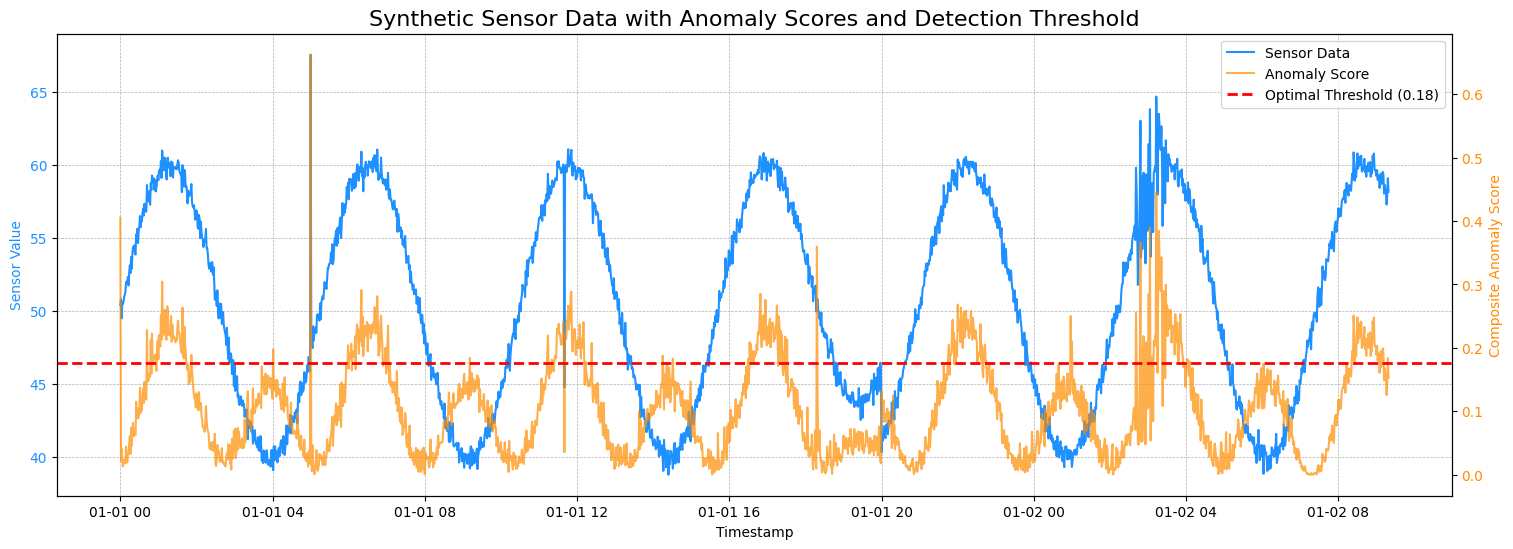

In [32]:
import matplotlib.pyplot as plt

# Create the plot with two y-axes
fig, ax1 = plt.subplots(figsize=(18, 6))

# Plot the sensor data on the primary y-axis (left)
ax1.plot(synthetic_df['timestamp'], synthetic_df['sensor_value'], color='dodgerblue', label='Sensor Data')
ax1.set_xlabel('Timestamp')
ax1.set_ylabel('Sensor Value', color='dodgerblue')
ax1.tick_params(axis='y', labelcolor='dodgerblue')
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

# Create a secondary y-axis (right) for the anomaly score
ax2 = ax1.twinx()
ax2.plot(synthetic_df['timestamp'], synthetic_df['composite_score'], color='darkorange', label='Anomaly Score', alpha=0.7)
ax2.set_ylabel('Composite Anomaly Score', color='darkorange')
ax2.tick_params(axis='y', labelcolor='darkorange')

# Draw the optimal threshold line
ax2.axhline(y=optimal_threshold, color='red', linestyle='--', linewidth=2, label=f'Optimal Threshold ({optimal_threshold:.2f})')

# Add a title and legend
plt.title('Synthetic Sensor Data with Anomaly Scores and Detection Threshold', fontsize=16)
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

plt.show()

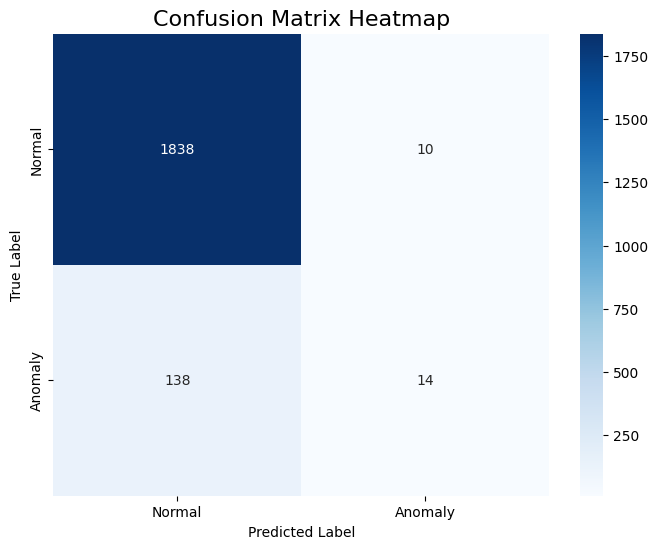

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- Generate the confusion matrix ---
# Make sure 'predictions' and the true labels ('y_synthetic' or 'df['label']') are available
cm = confusion_matrix(y_synthetic, predictions) # Or use df['label'] for the other notebook

# --- Create the heatmap ---
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Anomaly'],
            yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap', fontsize=16)
plt.show()